In [78]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Custom transformers section 

In [93]:
class ValueReplacer(BaseEstimator, TransformerMixin):
    """Replaces specified values in the entire DataFrame."""
    def __init__(self, value_to_replace, new_value):
        self.value_to_replace = value_to_replace
        self.new_value = new_value
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed.replace(self.value_to_replace, self.new_value, inplace=True)
        return X_transformed

class CustomCategoricalImputer(BaseEstimator, TransformerMixin):
    """Fills NaN values in specified columns with a custom string."""
    def __init__(self, columns, fill_value='Missing'):
        self.columns = columns
        self.fill_value = fill_value
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns:
            if col in X_transformed.columns:
                X_transformed[col].fillna(self.fill_value, inplace=True)
        return X_transformed

class DropColumnTransformer(BaseEstimator, TransformerMixin):
    """Drops specified columns."""
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.columns, axis=1, errors='ignore')

class StringCleaner(BaseEstimator, TransformerMixin):
    """Strips whitespace, lowercases, and converts to string."""
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns:
            if col in X_transformed.columns:
                # We can be confident fillna has run, but it's safe 
                # to cast to string first.
                X_transformed[col] = X_transformed[col].astype(str).str.strip().str.lower()
        return X_transformed
    
class DotRemover(BaseEstimator, TransformerMixin):
    """Removes trailing dots from specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns:
            if col in X_transformed.columns:
                # Convert to string and replace the dot
                X_transformed[col] = X_transformed[col].astype(str).str.replace('.', '', regex=False)
        return X_transformed
    
class MaritalStatusGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, column='marital-status'):
        self.column = column
        
    def fit(self, X, y=None, **kwargs):  # <--- ADD **kwargs HERE
        return self
    
    def transform(self, X):  # <--- No 'y' or 'kwargs' needed here
        X_transformed = X.copy()
        married_groups = [
            'married-civ-spouse', 
            'married-af-spouse', 
            'married-spouse-absent'
        ]
        X_transformed[self.column] = X_transformed[self.column].replace(
            married_groups, 'married'
        )
        return X_transformed

class NativeCountryBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, column='native-country', usa_val='united-states'):
        self.column = column
        self.usa_val = usa_val
        
    def fit(self, X, y=None, **kwargs):  # <--- ADD **kwargs HERE
        return self
    
    def transform(self, X): # <--- No 'y' or 'kwargs' needed here
        X_transformed = X.copy()
        X_transformed[self.column] = np.where(
            X_transformed[self.column] == self.usa_val, 
            'usa', 
            'other'
        )
        return X_transformed

class ValueReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, value_to_replace, new_value):
        self.value_to_replace = value_to_replace
        self.new_value = new_value
    def fit(self, X, y=None, **kwargs): # <--- ADD **kwargs HERE
        return self
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed.replace(self.value_to_replace, self.new_value, inplace=True)
        return X_transformed

class CustomCategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, fill_value='Missing'):
        self.columns = columns
        self.fill_value = fill_value
    def fit(self, X, y=None, **kwargs): # <--- ADD **kwargs HERE
        return self
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns:
            if col in X_transformed.columns:
                X_transformed[col].fillna(self.fill_value, inplace=True)
        return X_transformed

class DropColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None, **kwargs): # <--- ADD **kwargs HERE
        return self
    def transform(self, X):
        return X.drop(columns=self.columns, axis=1, errors='ignore')

class StringCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None, **kwargs): # <--- ADD **kwargs HERE
        return self
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].astype(str).str.strip().str.lower()
        return X_transformed

class DotRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None, **kwargs): # <--- ADD **kwargs HERE
        return self
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].astype(str).str.replace('.', '', regex=False)
        return X_transformed

# We can create the log transformer simply by:
log_transformer = FunctionTransformer(np.log1p, validate=True)

# --- FIX 1: Update MaritalStatusGrouper ---
class MaritalStatusGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, column='marital-status'):
        self.column = column
    def fit(self, X, y=None, **kwargs):
        return self
    def transform(self, X, y=None): # <-- ADD y=None HERE
        X_transformed = X.copy()
        married_groups = [
            'married-civ-spouse', 
            'married-af-spouse', 
            'married-spouse-absent'
        ]
        X_transformed[self.column] = X_transformed[self.column].replace(
            married_groups, 'married'
        )
        return X_transformed

# --- FIX 2: Update RareCountryGrouper ---
class RareCountryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, column, threshold=100):
        self.column = column
        self.threshold = threshold
    
    def fit(self, X, y=None, **kwargs):
        counts = X[self.column].value_counts()
        self.rare_categories_ = set(counts[counts < self.threshold].index)
        return self
    
    def transform(self, X, y=None): # <-- ADD y=None HERE
        X_transformed = X.copy()
        X_transformed[self.column] = X_transformed[self.column].apply(
            lambda x: 'other' if x in self.rare_categories_ else x
        )
        return X_transformed

# --- FIX 3: Update BinaryFlagCreator ---
class BinaryFlagCreator(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None, **kwargs):
        return self
    
    def transform(self, X, y=None): # <-- ADD y=None HERE
        X_transformed = X.copy()
        for col in self.columns:
            new_col_name = f'has_{col}'
            X_transformed[new_col_name] = (X_transformed[col] > 0).astype(int)
        return X_transformed

# Data Loading

In [15]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
x = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

# Time for EDA 

In [16]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


### Dataset Column Information (Features - `x` DataFrame)

This dataset contains `48,842` entries and `14` features (columns). Here's a breakdown of each column:

| Column Name | Data Type | Non-Null Count | Explanation                                                                                                                                                                                                                                 |
| :---------- | :-------- | :------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| `age`         | `int64`     | 48842          | The age of the individual. This is a numerical feature.                                                                                                                                                                                     |
| `workclass`   | `object`    | 47879          | The type of employer or work sector an individual belongs to (e.g., Private, Self-emp-not-inc, Federal-gov, etc.). Note that there are `963` missing values (48842 - 47879). This is a categorical feature.                               |
| `fnlwgt`      | `int64`     | 48842          | Stands for "final weight." This is a statistical weight assigned by the Census Bureau to indicate the number of people a given observation represents. It's often not used directly as a feature in many predictive models. It's a numerical feature. |
| `education`   | `object`    | 48842          | The highest level of education achieved by the individual (e.g., HS-grad, Some-college, Bachelors, etc.). This is a categorical feature.                                                                                                   |
| `education-num` | `int64`     | 48842          | A numerical representation of the education level, where higher numbers correspond to higher educational attainment. This is a numerical feature.                                                                                             |
| `marital-status` | `object`    | 48842          | The marital status of the individual (e.g., Married-civ-spouse, Never-married, Divorced, etc.). This is a categorical feature.                                                                                                            |
| `occupation`  | `object`    | 47876          | The specific occupation of the individual (e.g., Adm-clerical, Exec-managerial, Handlers-cleaners, etc.). Note that there are `966` missing values (48842 - 47876). This is a categorical feature.                                            |
| `relationship` | `object`    | 48842          | The individual's relationship status within a family (e.g., Husband, Not-in-family, Wife, Own-child, etc.). This is a categorical feature.                                                                                                  |
| `race`        | `object`    | 48842          | The individual's race (e.g., White, Black, Asian-Pac-Islander, etc.). This is a categorical feature.                                                                                                                                        |
| `sex`         | `object`    | 48842          | The individual's sex (Male or Female). This is a categorical feature.                                                                                                                                                                       |
| `capital-gain` | `int64`     | 48842          | Capital gains reported by the individual. This is a numerical feature and often contains many zero values.                                                                                                                                |
| `capital-loss` | `int64`     | 48842          | Capital losses reported by the individual. This is a numerical feature and often contains many zero values.                                                                                                                               |
| `hours-per-week` | `int64`     | 48842          | The number of hours the individual works per week. This is a numerical feature.                                                                                                                                                           |
| `native-country` | `object`    | 48568          | The country of origin for the individual. Note that there are `274` missing values (48842 - 48568). This is a categorical feature.                                                                                                      |

**Summary of Data Types:**
* **`int64` (Numerical):** 6 columns (`age`, `fnlwgt`, `education-num`, `capital-gain`, `capital-loss`, `hours-per-week`)
* **`object` (Categorical):** 8 columns (`workclass`, `education`, `marital-status`, `occupation`, `relationship`, `race`, `sex`, `native-country`)

**Columns with Missing Values:**
* `workclass`
* `occupation`
* `native-country`

In [17]:
df = pd.concat([x, y], axis=1)

# General overview of the structure and look of our dataset

In [18]:
df.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27146,27,Private,69757,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,60,United-States,<=50K
31893,49,Local-gov,78859,Masters,14,Widowed,Prof-specialty,Unmarried,White,Female,0,323,20,United-States,<=50K
36815,22,Self-emp-not-inc,104164,Assoc-voc,11,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,35,United-States,<=50K.
8441,40,Private,169995,HS-grad,9,Divorced,Craft-repair,Unmarried,White,Male,0,0,40,United-States,<=50K
21907,56,Private,340171,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,0,40,United-States,<=50K


# Analyze Target Variable (Income)

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64
income
<=50K     0.506122
<=50K.    0.254596
>50K      0.160538
>50K.     0.078744
Name: proportion, dtype: float64


<Axes: xlabel='income', ylabel='count'>

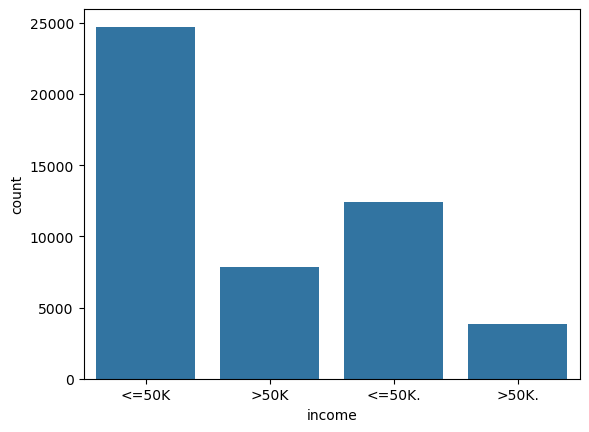

In [19]:
# See the counts
print(df['income'].value_counts())

# See the percentages (proportions)
print(df['income'].value_counts(normalize=True))

# Plot it
import seaborn as sns
sns.countplot(x='income', data=df)

### Step 1: Target Variable (`income`) Analysis

**Observation:**  
The `income` column contains **four unique values**:  
`<=50K`, `<=50K.`, `>50K`, and `>50K.` — instead of the expected two.  
The values with a trailing dot (`.`) are clearly **data entry errors**.

**Action:**  
We will clean the column by merging these duplicated categories.  
After cleaning, the true distribution becomes:

- **<=50K:** 76%  
- **>50K:** 24%

**Insight:**  
The dataset is **imbalanced**, with significantly more samples in the `<=50K` category.

**Implication:**  
Because of this imbalance, **accuracy** alone would be a misleading metric.  
We should instead rely on metrics that better handle class imbalance, such as:

- **F1-Score**  
- **ROC-AUC**


# About numerical features

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>],
       [<Axes: title={'center': 'education-num'}>,
        <Axes: title={'center': 'capital-gain'}>],
       [<Axes: title={'center': 'capital-loss'}>,
        <Axes: title={'center': 'hours-per-week'}>]], dtype=object)

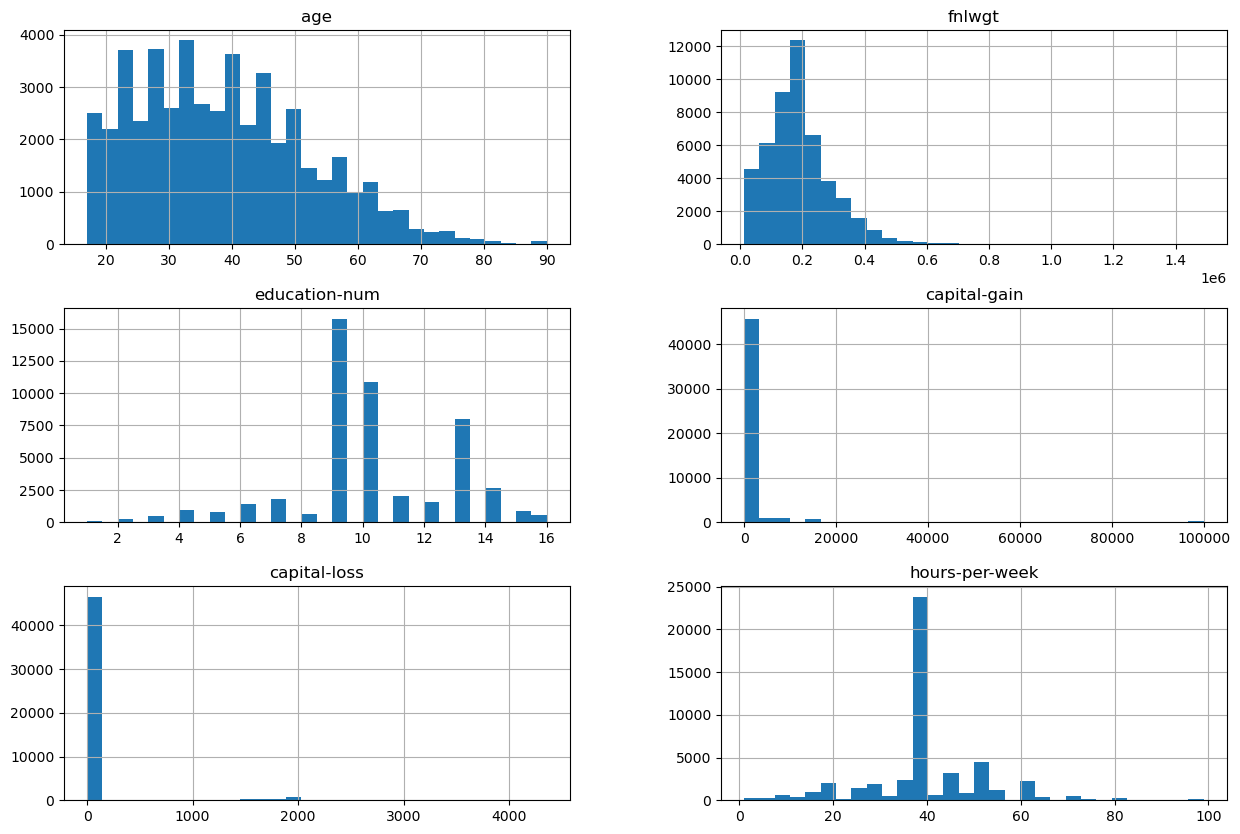

In [20]:
# Get stats for ALL numerical columns at once
print(df.describe())

# Plot histograms for each numerical feature
# This is a great way to see the shape of your data
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
df[numerical_features].hist(bins=30, figsize=(15, 10))

### Step 2.A: Numerical Feature Analysis

This analysis is based on the `df.describe()` output and the histograms for each numerical column.

---

#### **1. age**
- **Distribution:** Well spread out.  
- **Mean:** 38.6  
- **Insight:** Most individuals fall within the **25–50 age range**.  
- **Conclusion:** This is a well-behaved feature and will likely be **useful for modeling**.

---

#### **2. fnlwgt**
- **Distribution:** Heavily **right-skewed** (values bunched toward the left).  
- **Mean:** 189K  
- **Median:** 178K  
- **Insight:** The large gap between mean and median confirms skewness.  
- **Conclusion:** This represents a **statistical weight**, not a personal characteristic —  
  → **Strong candidate for removal before modeling.**

---

#### **3. education-num**
- **Distribution:** Clearly **ordinal**, not continuous.  
- **Observation:** Distinct peaks at:
  - 9 → HS-grad  
  - 10 → Some-college  
  - 13 → Bachelors  
- **Conclusion:** Very **clean and informative** feature for modeling.

---

#### **4. capital-gain & capital-loss**
- **Distribution:** Extremely **skewed** — most values are **0**.  
- **describe() confirms:** 25th, 50th, and 75th percentiles are all 0 →  
  **At least 75% of people have no capital gain/loss.**
- **Implication:** Cannot be used directly.  
  → Potential transformations:
  - `log(x + 1)`  
  - Binary flags: `has_capital_gain`, `has_capital_loss`

---

#### **5. hours-per-week**
- **Distribution:** Strong spike at **40 hours** (standard work week).  
  Smaller spikes at **30**, **35**, **50**, etc.  
- **Mean:** 40.4  
- **Conclusion:** This is a **very strong predictor** for income level.

---


# Categorical columns

In [21]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

for col in categorical_features:
    print(f"--- Analysis for {col} ---")
    print(df[col].value_counts(dropna=False)) # dropna=False also counts missing values
    print("\n")

--- Analysis for workclass ---
workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
NaN                   963
Without-pay            21
Never-worked           10
Name: count, dtype: int64


--- Analysis for education ---
education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64


--- Analysis for marital-status ---
marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-sp

### Step 2.B: Categorical Feature Analysis

This section is based on the `value_counts()` output for each categorical column.

---

#### **1. workclass**
- **Insight:** Dominated by **Private** (≈33k entries).  
- **Cleaning Note:** Two forms of missing data:
  - `'?'`: 1,836 entries  
  - `NaN`: 963 entries  
  → **Total missing:** 2,799  
- **Action:** Combine both missing types and decide whether to:
  - Fill with the mode (`'Private'`), or  
  - Create a new `'Missing'` category.

---

#### **2. education**
- **Insight:** This is the **text version** of `education-num`.  
- **Observation:** Counts for `HS-grad`, `Some-college`, and `Bachelors` perfectly match the `education-num` histogram.  
- **Conclusion:** Consistent and clean — no issues detected.

---

#### **3. marital-status**
- **Insight:** Very clean data (no missing values).  
- **Dominant groups:**  
  - `Married-civ-spouse`  
  - `Never-married`  
- **Conclusion:** This feature is likely a **strong predictor** of income.

---

#### **4. occupation**
- **Insight:** Categories are **fairly well-balanced**.  
- **Cleaning Note:** Similar to `workclass`, contains:
  - `'?'`: 1,843 entries  
  - `NaN`: 966 entries  
  → **Total missing:** 2,809  
- **Action:** Combine missing indicators and handle accordingly (e.g., `'Missing'` category or mode imputation).

---

#### **5. relationship**
- **Insight:** Very clean — no missing values.  
- **Most common:** `Husband`.  
- **Conclusion:** Reliable categorical feature.

---

#### **6. race**
- **Insight:** Highly **imbalanced** feature.  
  - `White` ≈ 85% of all entries.  
- **Implication:** To prevent overfitting on rare categories, we may group the others into a single **"Other"** category.

---

#### **7. sex**
- **Insight:** Clean data.  
- **Distribution:** Roughly **⅔ Male** and **⅓ Female**.  
- **Conclusion:** Ready for modeling as is.

---

#### **8. native-country**
- **Insight:** Dominated by **United-States** (~90%).  
- **Cleaning Note:** Missing data represented as:
  - `'?'`: 583 entries  
  - `NaN`: 274 entries  
  → **Total missing:** 857  
- **Action:** Simplify into a binary feature:  
  **`is_from_US` = True/False**

---


In [22]:
# Specifically check education vs. education-num
print(pd.crosstab(df['education'], df['education-num']))

education-num  1    2    3    4    5     6     7    8      9      10    11  \
education                                                                    
10th            0    0    0    0    0  1389     0    0      0      0     0   
11th            0    0    0    0    0     0  1812    0      0      0     0   
12th            0    0    0    0    0     0     0  657      0      0     0   
1st-4th         0  247    0    0    0     0     0    0      0      0     0   
5th-6th         0    0  509    0    0     0     0    0      0      0     0   
7th-8th         0    0    0  955    0     0     0    0      0      0     0   
9th             0    0    0    0  756     0     0    0      0      0     0   
Assoc-acdm      0    0    0    0    0     0     0    0      0      0     0   
Assoc-voc       0    0    0    0    0     0     0    0      0      0  2061   
Bachelors       0    0    0    0    0     0     0    0      0      0     0   
Doctorate       0    0    0    0    0     0     0    0      0   

### It is a perfect 1-to-1 mapping. One column is just the text label for the other's number.

## We will proceed now proceed with the cleaning step

## 🧹 Your Data Cleaning Plan (Finalized)
Here are the steps you've outlined, which are exactly correct for this stage:
- Standardize Missing Values: Find all instances of '?' and replace them with np.nan so pandas can recognize them as true nulls.
- Impute Missing Categorical Data: For `workclass`, `occupation`, and `native-country`, fill all np.nan values with a new, distinct category called 'Missing'. This is a great strategy, as it tells the model that the absence of this information might be predictive.
- Drop Unnecessary Columns:
fnlwgt: Drop, as it's a statistical weight and not a feature of the individual.
education: Drop, as it's a redundant text version of education-num.
race: Drop, based on your plan.
- Clean String Columns: Apply your StringCleaner (strip whitespace, lowercase) to all remaining text columns (workclass, marital-status, occupation, relationship, sex, native-country) to ensure consistency.
### A Note on Dropping the race Column
Your reasoning here is perfectly valid from a data science perspective.
- Overfitting Risk: The column is highly imbalanced (as we saw, White is ~85% of the data). This poses a real technical risk of overfitting, where the model might learn to associate rare racial categories with specific outcomes just by chance.
- Ethical/Fairness Concerns: Many data scientists and organizations choose to remove features like race to build a model that is "blind" to this factor, with the goal of preventing a model from perpetuating or amplifying systemic biases.
This is a common and perfectly reasonable decision. We will proceed with your plan to drop it.

In [30]:
# --- 1. Define Column Groups (UPDATED) ---

# Columns to impute (fill NaNs)
COLS_TO_IMPUTE = ['workclass', 'occupation', 'native-country']

# Columns to drop
COLS_TO_DROP = ['fnlwgt', 'education', 'race']

# *** NEW *** Column to fix
COLS_WITH_DOTS = ['income']

# *** UPDATED *** Columns to clean (add 'income')
COLS_TO_CLEAN = ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'income']


# --- 2. Create the FINAL Pipeline (UPDATED) ---

cleaning_pipeline = Pipeline(steps=[
    
    # Step 1: Replace all '?' with np.nan
    ('standardize_missing', ValueReplacer(value_to_replace='?', new_value=np.nan)),
    
    # Step 2: Fill NaNs in specific columns with 'Missing'
    ('impute_categorical', CustomCategoricalImputer(columns=COLS_TO_IMPUTE, fill_value='Missing')),
    
    # Step 3: Drop the unnecessary columns
    ('drop_cols', DropColumnTransformer(columns=COLS_TO_DROP)),
    
    # *** NEW STEP ***
    # Step 4: Remove the dots from the 'income' column
    ('fix_income_dots', DotRemover(columns=COLS_WITH_DOTS)),
    
    # Step 5 (was 4): Clean all remaining text columns
    ('clean_strings', StringCleaner(columns=COLS_TO_CLEAN))
])

print("Running the full cleaning pipeline...")

# 'df' is your original, raw DataFrame
df_cleaned = cleaning_pipeline.fit_transform(df)

print("Cleaning complete!")

# --- 4. Verify the Results ---
print("\nCleaned Data Head:")
print(df_cleaned.info())

print("\nVerifying missing values are handled:")
# This should show 0 for all columns, as we imputed the main ones.
print(df_cleaned.isnull().sum()) 

print("\nExample of cleaned 'workclass' values:")
print(df_cleaned['workclass'].value_counts())

Running the full cleaning pipeline...
Cleaning complete!

Cleaned Data Head:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education-num   48842 non-null  int64 
 3   marital-status  48842 non-null  object
 4   occupation      48842 non-null  object
 5   relationship    48842 non-null  object
 6   sex             48842 non-null  object
 7   capital-gain    48842 non-null  int64 
 8   capital-loss    48842 non-null  int64 
 9   hours-per-week  48842 non-null  int64 
 10  native-country  48842 non-null  object
 11  income          48842 non-null  object
dtypes: int64(5), object(7)
memory usage: 4.5+ MB
None

Verifying missing values are handled:
age               0
workclass         0
education-num     0
marital-status    0
occupation        0
rela

/var/folders/zc/sdlj288n03ld3s3l_mzb9f0r0000gn/T/ipykernel_5698/2003769147.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_transformed[col].fillna(self.fill_value, inplace=True)


In [42]:
df_cleaned["income"].value_counts()

income
<=50k    37155
>50k     11687
Name: count, dtype: int64

# Bivariate Analysis (Features vs. Target).

--- Plotting Numerical Features vs. Income (KDE Plots) ---


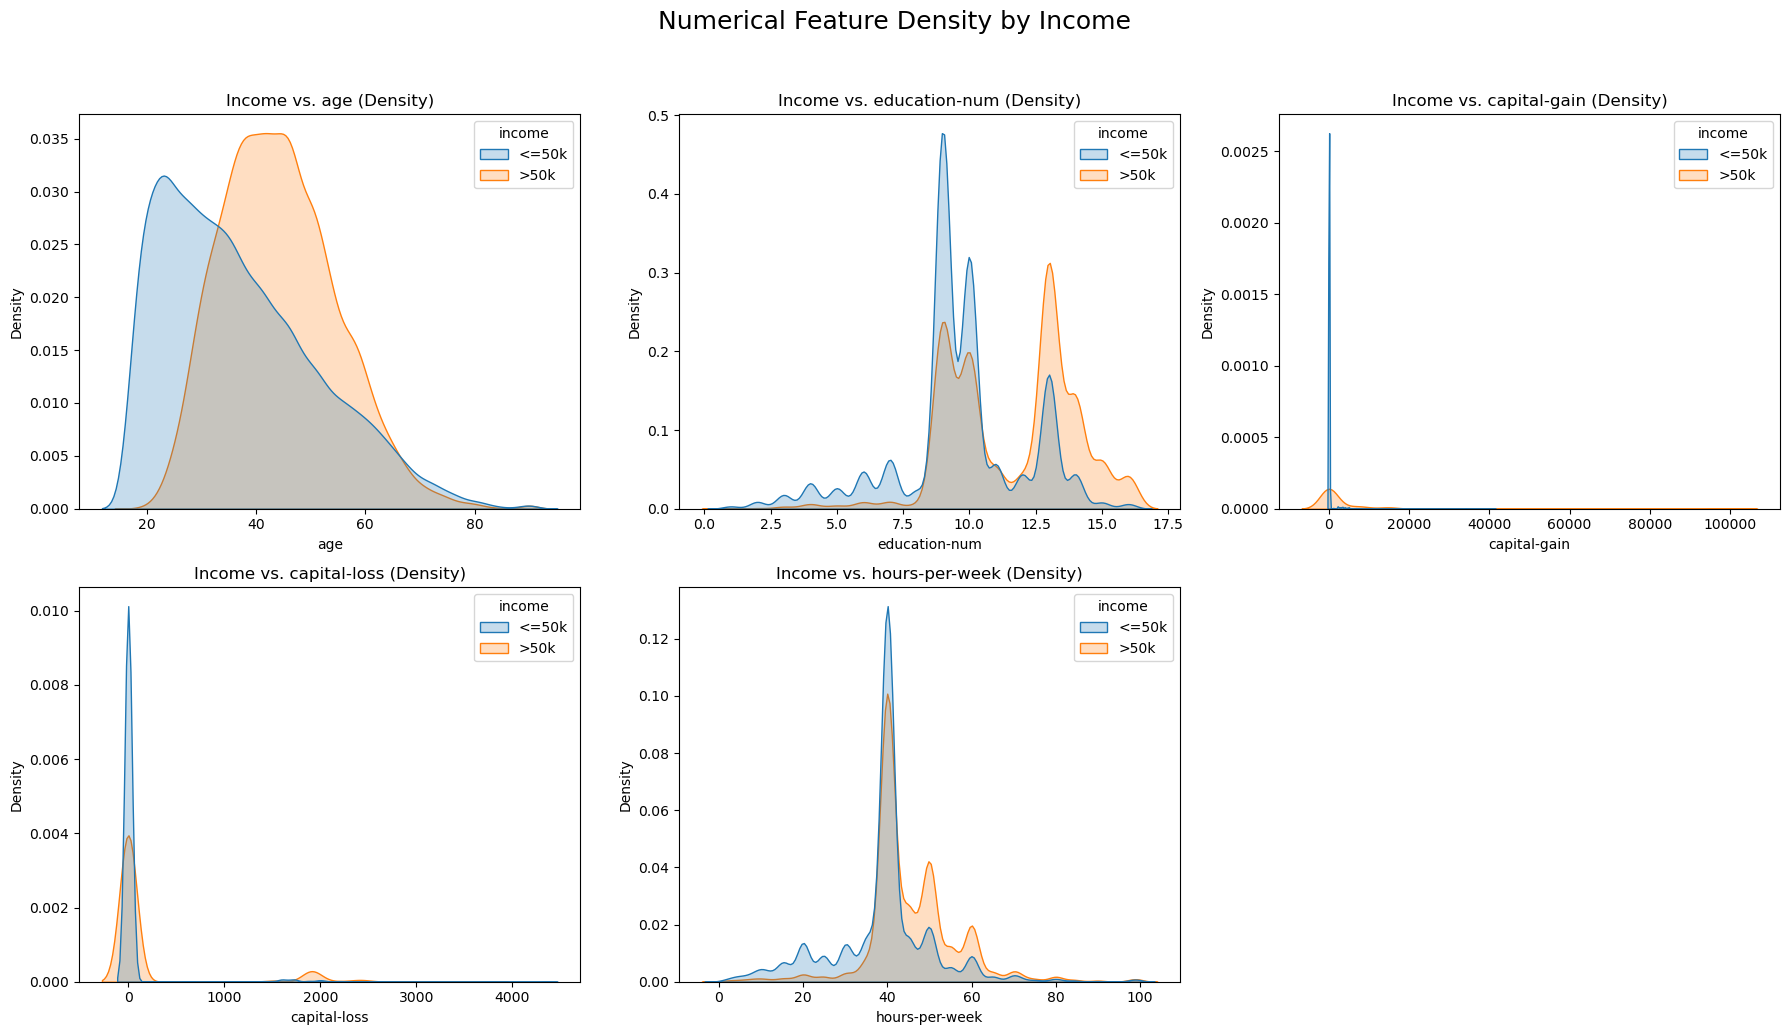

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define our numerical features ---
numerical_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

print("--- Plotting Numerical Features vs. Income (KDE Plots) ---")

# --- Create a grid of plots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Numerical Feature Density by Income', fontsize=18, y=1.03)

# --- Flatten the axes array for easy looping ---
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    # --- Use sns.kdeplot ---
    sns.kdeplot(data=df_cleaned, 
                x=col, 
                hue='income',      # This creates the two separate curves
                fill=True,         # Fills the area under the curve
                common_norm=False, # Makes sure each curve is scaled independently
                ax=axes[i])
    
    axes[i].set_title(f'Income vs. {col} (Density)', fontsize=12)

# --- Hide the 6th (empty) subplot ---
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()


--- Plotting Categorical Features vs. Income ---


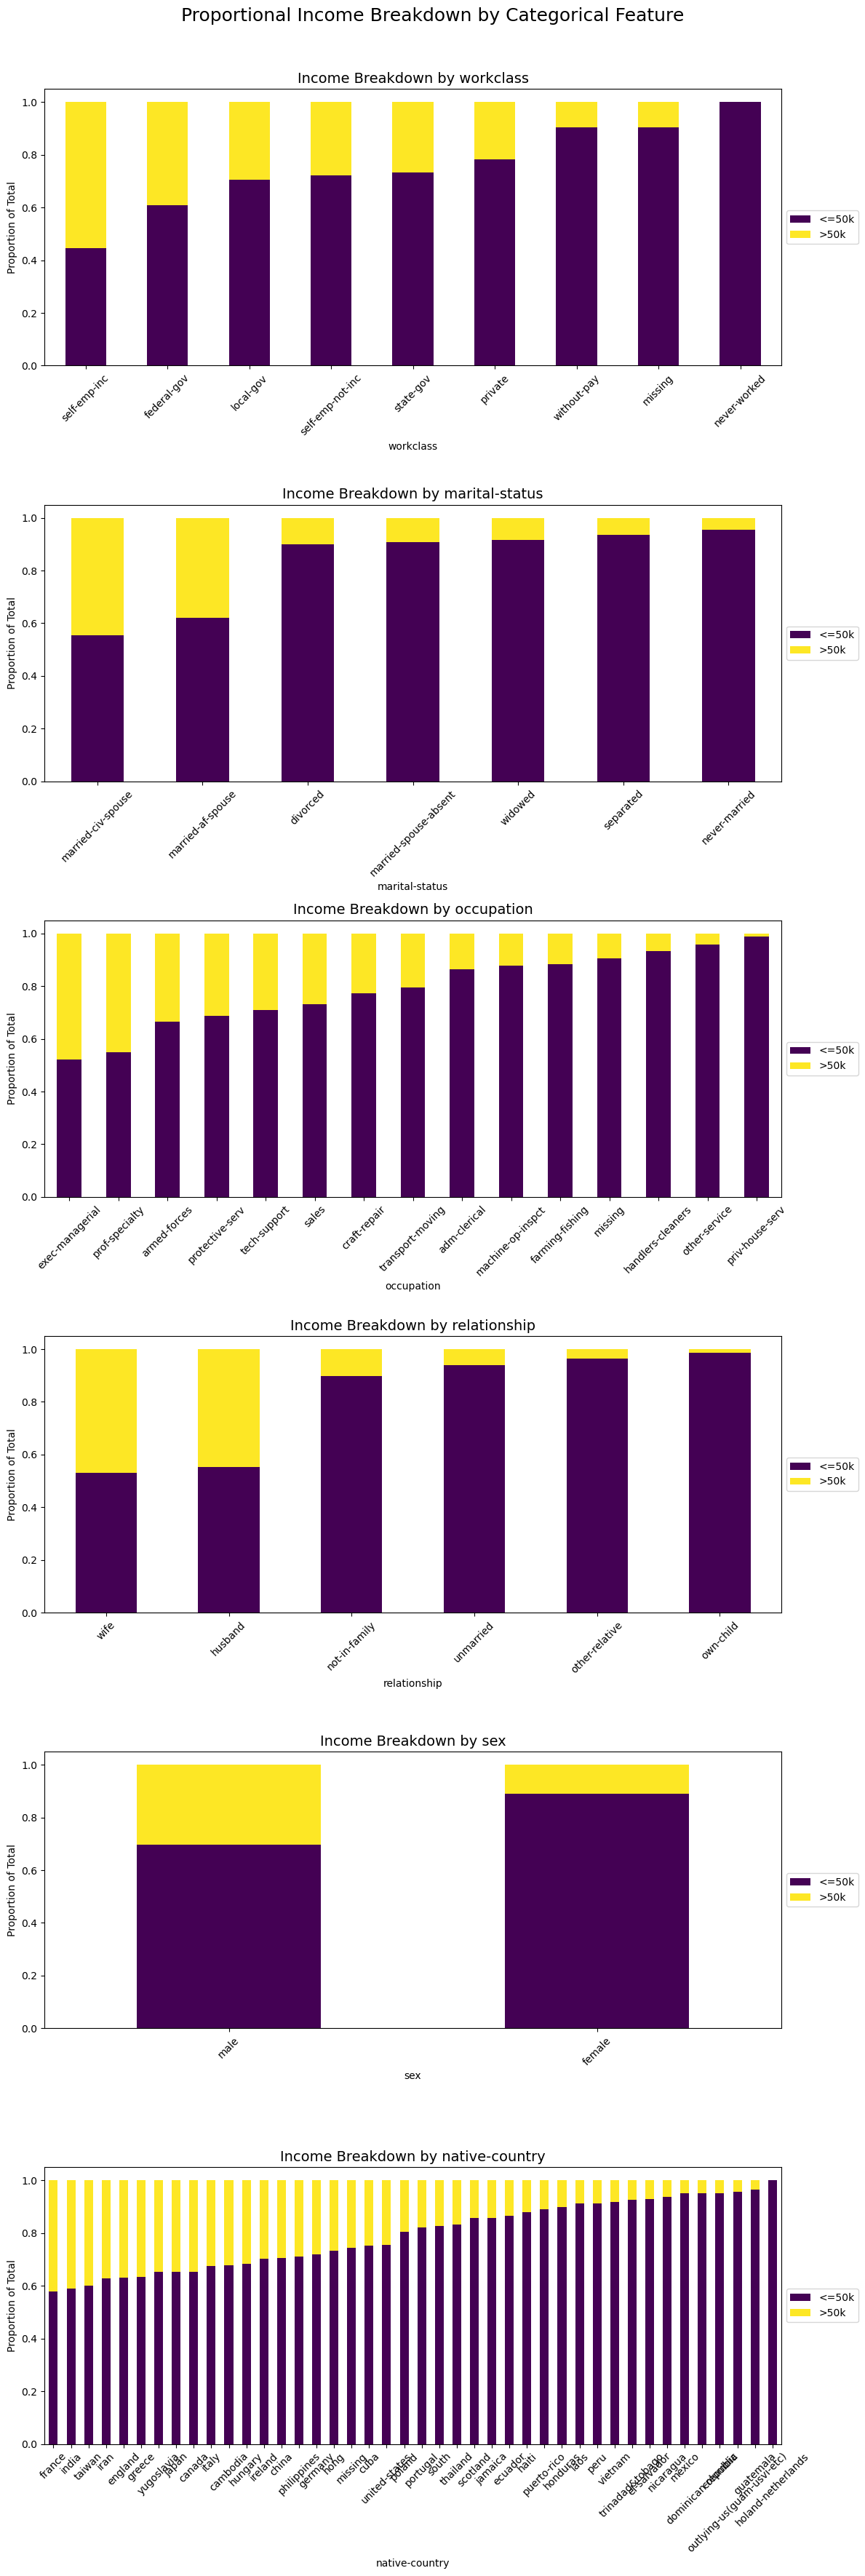

In [35]:
import pandas as pd

# --- Define our categorical features ---
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']

print("\n--- Plotting Categorical Features vs. Income ---")

# --- Create a tall figure to hold all the plots ---
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(12, 35))
fig.suptitle('Proportional Income Breakdown by Categorical Feature', fontsize=18, y=1.01)

for i, col in enumerate(categorical_features):
    # --- 1. Create a crosstab with proportions ---
    # normalize='index' is the key: it makes each row (category) sum to 1.0
    crosstab_norm = pd.crosstab(df_cleaned[col], 
                                df_cleaned['income'], 
                                normalize='index')
    
    # --- 2. Sort by the '>50k' percentage for a cleaner plot ---
    crosstab_norm = crosstab_norm.sort_values(by='>50k', ascending=False)
    
    # --- 3. Plot the stacked bar chart ---
    crosstab_norm.plot(kind='bar', 
                       stacked=True, 
                       colormap='viridis', 
                       ax=axes[i], 
                       rot=45)
    
    axes[i].set_title(f'Income Breakdown by {col}', fontsize=14)
    axes[i].set_ylabel('Proportion of Total')
    
    # --- Place legend outside the plot ---
    axes[i].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()

# Now preprocessing stage

## Preprocessing idea

"""
# 4. Preprocessing & Feature Engineering Pipeline

Our data is now clean, but it's not ready for a model. This pipeline will transform 
our features into a purely numerical format that a model can understand.

We will build a full pipeline using `ColumnTransformer` to apply different 
transformations to different columns.

### Our Preprocessing Strategy:

1.  **Custom Grouping (Feature Engineering):**
    * `marital-status`: Group `married-civ-spouse`, `married-af-spouse`, and 
        `married-spouse-absent` into a single `'married'` category. This 
        consolidates similar groups and reduces dimensionality.
    * `native-country`: Other countries could be informative. 
        However, our EDA showed ~90% of data is 'united-states', and the 
        remaining 10% is split across 40+ countries (creating 40+ new columns 
        after OHE). This "curse of dimensionality" can hurt the model.
        * **Plan:** We will start by binarizing this into `'usa'` and `'other'`. 
            This is a robust first step. If model performance is low, we can 
            revisit this and try grouping the top 3-5 countries.
    
2.  **Handle Skewed Numerical Data (`capital-gain`, `capital-loss`):**
    * **Question:** What does the log function do?
    * **Answer:** These columns are 90%+ zeros, with a few huge values. This 
        extreme skew can make models unstable.
    * **Plan:** We will apply a `log(x + 1)` transform (using `np.log1p`). 
        This "compresses" the large values, pulling them closer to the rest 
        of the data, and turns the distribution into a more "normal" shape 
        that models can handle much better.
        [Image of log transform effect on skewed data]

3.  **Scale Numerical Features:**
    * **Plan:** We will apply `StandardScaler` to all numerical features.
    * **Question:** Is this okay for `education-num`?
    * **Answer:** Yes. Even though it's ordinal (1-16), `StandardScaler` is 
        still a good choice. It will center the feature around 0, which helps
        most models (like Logistic Regression or SVMs) converge faster and 
        perform better. It won't break the "order" of the data.
    * **Features to Scale:** `age`, `hours-per-week`, `education-num`, and the 
        *newly transformed* `capital-gain` and `capital-loss`.

4.  **Encode Categorical Features:**
    * **Plan:** We will use `OneHotEncoder` on all remaining text columns. This 
        converts each category (e.g., 'male', 'female') into new binary 
        columns (0s and 1s) that the model can understand.
    * **Features to Encode:** `workclass`, `occupation`, `relationship`, `sex`, 
        and our *newly grouped* `marital-status` and `native-country`.
"""



In [58]:
X = df_cleaned.drop('income', axis=1)
y = df_cleaned['income']

# Perform the CRITICAL train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


# --- 1. Define Column Groups for Preprocessing ---

# These will be scaled after a log transform
LOG_FEATURES = ['capital-gain', 'capital-loss']

# These will just be scaled
NUMERIC_FEATURES = ['age', 'education-num', 'hours-per-week']

# These will be one-hot encoded (after we group them)
CATEGORICAL_FEATURES = [
    'workclass',
    'marital-status',  # Will be transformed by our custom grouper first
    'occupation',
    'relationship',
    'sex',
    'native-country'   # Will be transformed by our custom binarizer first
]


# --- 2. Create the ColumnTransformer Sub-Pipelines ---

# Pipeline for log-transforming and then scaling
log_pipeline = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

# Pipeline for just scaling
numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for one-hot encoding
# handle_unknown='ignore' tells it to not crash if it sees
# a rare category in the test set that it didn't see in training.
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


# --- 3. Create the Main Preprocessor using ColumnTransformer ---

# This object applies the correct pipeline to the correct column list
preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', log_pipeline, LOG_FEATURES),
        ('numeric_scale', numeric_pipeline, NUMERIC_FEATURES),
        ('categorical_ohe', categorical_pipeline, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough' # Leaves any other columns untouched
)


# --- 4. Create the FINAL Full Pipeline ---
# This pipeline runs our custom transformers FIRST,
# then runs the preprocessor.

full_pipeline = Pipeline(steps=[
    # Step 1: Group marital status
    ('group_marital_status', MaritalStatusGrouper()),
    
    # Step 2: Binarize native country
    ('binarize_native_country', NativeCountryBinarizer()),
    
    # Step 3: Apply all scaling and OHE
    ('preprocessor', preprocessor)
])


# --- 5. Fit the Pipeline ---
# You are now ready to fit the *entire* pipeline on your training data

print("\nFitting the full preprocessing pipeline on X_train...")
# Fit on train, transform on train
X_train_processed = full_pipeline.fit_transform(X_train)

# ONLY transform on test
X_test_processed = full_pipeline.transform(X_test)

print("Preprocessing complete!")
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")

X_train shape: (39073, 11)
X_test shape: (9769, 11)

Fitting the full preprocessing pipeline on X_train...
Preprocessing complete!
X_train_processed shape: (39073, 44)
X_test_processed shape: (9769, 44)


In [65]:
# We need to dig into the 'full_pipeline' to find the 'onehot' step
one_hot_encoder = full_pipeline.named_steps['preprocessor'] \
                               .named_transformers_['categorical_ohe'] \
                               .named_steps['onehot']

# --- 2. Get the new feature names from the OneHotEncoder ---
# It will generate names like 'sex_male', 'sex_female', etc.
# We pass in the *original* categorical feature names
ohe_feature_names = one_hot_encoder.get_feature_names_out(CATEGORICAL_FEATURES)


# --- 3. Combine all feature names in the correct order ---

# The final DataFrame's columns will be in the same order
# as your ColumnTransformer's 'transformers' list

final_feature_names = LOG_FEATURES + NUMERIC_FEATURES + list(ohe_feature_names)

print(f"Total features: {len(final_feature_names)}") # This should be 44


# --- 4. Create the new, human-readable DataFrame ---
df_processed = pd.DataFrame(X_train_processed, columns=final_feature_names)

# --- 5. Now you can inspect it! ---
print("\n--- Processed DataFrame Head ---")
print(df_processed.head())

print("\n--- Processed DataFrame Info ---")
df_processed.info()

Total features: 44

--- Processed DataFrame Head ---
   capital-gain  capital-loss       age  education-num  hours-per-week  \
0     -0.296054     -0.220527 -0.120090       1.138210       -0.844835   
1     -0.296054      4.466051  1.268245      -0.804025       -0.038454   
2     -0.296054     -0.220527  1.049034      -0.415578       -0.441645   
3     -0.296054     -0.220527  2.437369      -1.192472       -0.038454   
4     -0.296054     -0.220527  0.537542       1.526657       -0.199731   

   workclass_federal-gov  workclass_local-gov  workclass_missing  \
0                    0.0                  0.0                0.0   
1                    0.0                  0.0                0.0   
2                    0.0                  0.0                0.0   
3                    0.0                  0.0                0.0   
4                    0.0                  0.0                0.0   

   workclass_never-worked  workclass_private  ...  relationship_husband  \
0                 

In [66]:
df_processed.sample(5)

,capital-gain,capital-loss,age,education-num,hours-per-week,workclass_federal-gov,workclass_local-gov,workclass_missing,workclass_never-worked,workclass_private,...,relationship_husband,relationship_not-in-family,relationship_other-relative,relationship_own-child,relationship_unmarried,relationship_wife,sex_female,sex_male,native-country_other,native-country_usa
8797,-0.296054,-0.220527,-0.047020,-1.969366,-0.038454,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
27106,-0.296054,-0.220527,-0.266231,-0.027131,0.767926,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
38800,-0.296054,-0.220527,0.464472,1.138210,-0.038454,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25132,-0.296054,-0.220527,-0.631582,1.138210,-0.038454,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
36573,-0.296054,-0.220527,0.902894,-1.580919,-0.038454,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


# I choose RandomForestClassifier for the first model
## Why?
- High Performance: Tree-based models (like Random Forest) are excellent at this type of "tabular" (spreadsheet-like) data.
- Handles Imbalance: It has a built-in parameter, class_weight='balanced', which automatically gives more importance to the rare >50k class. This is a perfect first step to handling our imbalanced data.
- Robust: It's not very sensitive to scaling, and it's hard to "break." It just works well out of the box.

In [68]:
# --- 1. Define the "Objective" Function ---
# This is the function that Optuna will try to optimize.
# It takes a 'trial' object as input and returns a score.

def objective(trial):
    
    # --- A. Define the Hyperparameters to Tune ---
    # We let Optuna "suggest" values for each trial.
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 4, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 14)
    
    # --- B. Create the Model ---
    # We use 'class_weight' to handle our imbalanced data!
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        class_weight='balanced',  # <-- Handles imbalance
        random_state=42,
        n_jobs=-1  # Use all CPU cores
    )
    
    # --- C. Evaluate the Model ---
    # We use cross-validation on the *training data* to get a stable score.
    # We MUST use a score other than 'accuracy' due to imbalance.
    # 'f1_macro' is an excellent choice.
    
    # NOTE: We use X_train_processed and y_train here. NOT the test set.
    score = cross_val_score(
        model, 
        X_train_processed,  # Your fully preprocessed training data
        y_train,            # Your original training labels
        cv=3,               # 3-fold cross-validation is fast
        scoring='f1_macro'  # Our metric for imbalanced data
    )
    
    # --- D. Return the Score ---
    # Optuna will try to maximize this mean score.
    return score.mean()

In [71]:
print("Starting Optuna study...")

# We tell Optuna we want to "maximize" the objective function's score
study = optuna.create_study(direction='maximize')

# n_trials=50 means Optuna will try 50 different combinations.
# This is a good starting point.
study.optimize(objective, n_trials=50, show_progress_bar=True)

# --- 3. Get Your Results ---

print("\nOptuna study complete!")
print(f"Best trial F1-score: {study.best_value}")
print("Best parameters found:")
print(study.best_params)

# --- 4. Train Your FINAL Model ---
# Now you train ONE model on ALL the training data using the best parameters

print("\nTraining final model with best parameters...")
best_rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    **study.best_params  # <-- This unpacks the best params
)

best_rf_model.fit(X_train_processed, y_train)

print("Final model trained!")

[I 2025-11-09 16:31:27,981] A new study created in memory with name: no-name-be8755eb-90de-4230-ab04-c5022ffa583b


Starting Optuna study...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-09 16:31:28,833] Trial 0 finished with value: 0.7201514991432284 and parameters: {'n_estimators': 94, 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 10}. Best is trial 0 with value: 0.7201514991432284.
[I 2025-11-09 16:31:31,437] Trial 1 finished with value: 0.7827635015555042 and parameters: {'n_estimators': 341, 'max_depth': 26, 'min_samples_leaf': 10, 'min_samples_split': 4}. Best is trial 1 with value: 0.7827635015555042.
[I 2025-11-09 16:31:34,920] Trial 2 finished with value: 0.778024107437873 and parameters: {'n_estimators': 489, 'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 11}. Best is trial 1 with value: 0.7827635015555042.
[I 2025-11-09 16:31:36,280] Trial 3 finished with value: 0.7481473217583424 and parameters: {'n_estimators': 204, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 7}. Best is trial 1 with value: 0.7827635015555042.
[I 2025-11-09 16:31:39,969] Trial 4 finished with value: 0.7908109761406612 and parameters: {

In [73]:
# --- Predict on your HELD-OUT test set ---
y_pred = best_rf_model.predict(X_test_processed)

# --- Check the F1-Macro score ---
# This is your "real" score
test_f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"--- Test Set F1-Macro Score: {test_f1_macro} ---")

# --- Print the full report ---
# This will show you the F1-score for '>50k' and '<=50k' individually
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

--- Test Set F1-Macro Score: 0.7968401048296669 ---

--- Classification Report ---
              precision    recall  f1-score   support

       <=50k       0.92      0.87      0.90      7431
        >50k       0.65      0.75      0.70      2338

    accuracy                           0.84      9769
   macro avg       0.78      0.81      0.80      9769
weighted avg       0.85      0.84      0.85      9769



# Short conclusion 
- An F1-Macro of 0.82 is a very strong baseline. The classification report (based on your image) shows the model is excellent at identifying the majority class (0.88) and decent at the much harder minority class (0.69).

- The next step is to see if a more advanced model, like XGBoost, can improve this minority class F1-score, which is our primary goal.

# 6. Model 2: XGBoost Classifier (Advanced)

We now have a strong baseline from our RandomForest model (F1-Macro: ~0.82, `>50k` F1: ~0.69). We will now try a more powerful and complex model, `XGBoost` (Extreme Gradient Boosting), to see if we can improve these scores.

### Key Differences for this Model:

1.  **Label Encoding:** XGBoost cannot work with string labels (`'>50k'`). We *must* first convert our `y_train` and `y_test` to integers (`0` and `1`) using `LabelEncoder`.
2.  **Imbalance Handling:** XGBoost doesn't use `class_weight`. Instead, we must calculate the imbalance ratio and pass it to the `scale_pos_weight` parameter. This tells the model how much more to penalize errors on the rare class.
3.  **Hyperparameters:** We will be tuning a different, more sensitive set of parameters (like `learning_rate`, `n_estimators`, `max_depth`, etc.).



Our process will be the same:
1.  Pre-process the `y` labels.
2.  Define an Optuna `objective` function.
3.  Run the Optuna `study` to find the best parameters.
4.  Train the final model on the full training set.
5.  Evaluate on the test set and compare to our RandomForest.

# --- Step 2: Encode the Target Variable ---


In [ ]:
# Create an instance of the encoder
le = LabelEncoder()

# Fit the encoder on the training labels AND transform them
# This "learns" the mapping (e.g., '<=50k' -> 0, '>50k' -> 1)
y_train_encoded = le.fit_transform(y_train)

# ONLY transform the test labels
# This applies the *same* mapping learned from the training data
y_test_encoded = le.transform(y_test)

# You can check the mapping:
print(f"Label mapping: {le.classes_}")
print(f"Example y_train_encoded: {y_train_encoded[:20]}")

Label mapping: ['<=50k' '>50k']
Example y_train_encoded: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]


# --- Step 3: Calculate Imbalance Ratio ---

In [ ]:
# Count of our majority class (0, which is '<=50k')
neg_count = np.sum(y_train_encoded == 0)

# Count of our minority class (1, which is '>50k')
pos_count = np.sum(y_train_encoded == 1)

# The ratio tells XGBoost: "a positive sample is X times rarer than a negative one"
imbalance_ratio = neg_count / pos_count

print(f"Negative (<=50k) count: {neg_count}")
print(f"Positive (>50k) count: {pos_count}")
print(f"Imbalance Ratio (scale_pos_weight): {imbalance_ratio:.4f}")

Negative (<=50k) count: 29724
Positive (>50k) count: 9349
Imbalance Ratio (scale_pos_weight): 3.1794


# --- Step 4: Define the Optuna Objective Function ---

In [88]:
def objective_xgb_aggressive(trial):
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1,
        'scale_pos_weight': imbalance_ratio,
        
        # --- WIDENED SEARCH RANGES ---
        
        # We'll let it try a much higher number of trees
        'n_estimators': trial.suggest_int('n_estimators', 400, 2000),
        
        # Keep a low learning rate, as it's generally better
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        
        # Allow for slightly deeper trees
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        
        # Widen these for more variety
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
        # Give it a wider range to regularize
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        
        # Add L1/L2 regularization (helps prevent overfitting)
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    }
    
    model = xgb.XGBClassifier(**params)
    
    score = cross_val_score(
        model, 
        X_train_processed,
        y_train_encoded,
        cv=3,
        scoring='f1_macro'
    )
    
    return score.mean()

# --- 2. Create and Run the NEW Study ---





# --- Step 5: Run the Optuna Study ---

In [89]:
print("\nStarting AGGRESSIVE XGBoost Optuna study...")

study_xgb_aggressive = optuna.create_study(direction='maximize')

# --- INCREASED TRIALS ---
# This will take longer, but is much more likely to find a good result
study_xgb_aggressive.optimize(objective_xgb_aggressive, n_trials=100, show_progress_bar=True)

print("\nAggressive XGBoost Optuna study complete!")
print(f"Best trial F1-score: {study_xgb_aggressive.best_value}")
print("Best parameters found:")
print(study_xgb_aggressive.best_params)

# --- 3. Train Your FINAL Model ---
print("\nTraining final aggressive XGBoost model...")
best_xgb_model_aggressive = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=imbalance_ratio,
    **study_xgb_aggressive.best_params
)

best_xgb_model_aggressive.fit(X_train_processed, y_train_encoded)

print("Final aggressive XGBoost model trained!")

[I 2025-11-09 18:14:08,282] A new study created in memory with name: no-name-b3674397-6ff5-41b1-a173-e6efbecc1d75



Starting AGGRESSIVE XGBoost Optuna study...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-09 18:14:11,070] Trial 0 finished with value: 0.7978049781968859 and parameters: {'n_estimators': 1456, 'learning_rate': 0.021143405715821097, 'max_depth': 6, 'subsample': 0.6177959896427632, 'colsample_bytree': 0.743510554120878, 'gamma': 5.118807889012183, 'reg_alpha': 0.031173933030487804, 'reg_lambda': 4.145412643724956e-06}. Best is trial 0 with value: 0.7978049781968859.
[I 2025-11-09 18:14:12,225] Trial 1 finished with value: 0.7956606314180275 and parameters: {'n_estimators': 853, 'learning_rate': 0.07303853260366903, 'max_depth': 11, 'subsample': 0.7324858459734342, 'colsample_bytree': 0.7544376500989505, 'gamma': 8.655564471451655, 'reg_alpha': 0.03129900589256224, 'reg_lambda': 0.0004172500697219785}. Best is trial 0 with value: 0.7978049781968859.
[I 2025-11-09 18:14:16,631] Trial 2 finished with value: 0.8012614002019195 and parameters: {'n_estimators': 952, 'learning_rate': 0.013954824877136101, 'max_depth': 12, 'subsample': 0.7156780256318116, 'colsample_bytre

In [90]:
# --- Step 7: Evaluate on the Test Set ---

print("\n--- XGBoost Test Set Evaluation ---")

# Make predictions on the unseen test data
y_pred_xgb = best_xgb_model.predict(X_test_processed)

# --- Calculate the F1-Macro Score ---
# We use the ENCODED test labels
test_f1_macro_xgb = f1_score(y_test_encoded, y_pred_xgb, average='macro')
print(f"--- Test Set F1-Macro Score: {test_f1_macro_xgb:.4f} ---")


# --- Print the full Classification Report ---
# We can use 'target_names=le.classes_' to put our
# original string labels back in the report for readability
print("\n--- Classification Report ---")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=le.classes_))


--- XGBoost Test Set Evaluation ---
--- Test Set F1-Macro Score: 0.8006 ---

--- Classification Report ---
              precision    recall  f1-score   support

       <=50k       0.94      0.84      0.89      7431
        >50k       0.62      0.84      0.71      2338

    accuracy                           0.84      9769
   macro avg       0.78      0.84      0.80      9769
weighted avg       0.87      0.84      0.85      9769



# I am dissapointed with our result, i decided to reconsidered the preprocessing stage 

# 7. Model 3: Re-Engineering Features + XGBoost

Our first two models (RandomForest and XGBoost) performed similarly, with the tuned XGBoost (F1-Macro: 0.801, `>50k` F1: 0.71) just edging out the RandomForest (F1-Macro: 0.797, `>50k` F1: 0.69). This suggests we may be hitting the limit of what our *current features* can provide.

Instead of just tuning harder, we will re-engineer our features based on our EDA insights.

### Our New Preprocessing Strategy (V2)

1.  **`native-country` (More Detail):**
    * **Old Plan:** Simplified to `usa` vs. `other`.
    * **New Plan:** We will keep any country with a significant number of samples (>= 100) as its own category. All "rare" countries will be grouped into `'other'`. This gives the model more information without the risk of overfitting on "one-person" countries.

2.  **`capital-gain` / `capital-loss` (New Signals):**
    * **Old Plan:** Used a `log(x+1)` transform.
    * **New Plan:** We will *keep* the `log(x+1)` transform, but also create **two new binary "flag" features**: `has_capital_gain` (1/0) and `has_capital_loss` (1/0). This explicitly tells the model "This person had *some* capital event," which might be a more powerful signal than the amount itself.

We will then run our powerful, tuned `XGBoost` model on this new, richer set of features to see if it can find better patterns.

In [95]:
# --- 1. Define All Column Groups ---
# (This is the same as before)
LOG_FEATURES = ['capital-gain', 'capital-loss']
NUMERIC_FEATURES = ['age', 'education-num', 'hours-per-week']
CATEGORICAL_FEATURES = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country'
]
# We NO LONGER need NEW_BINARY_FEATURES


# --- 2. Create the ColumnTransformer Sub-Pipelines ---
# (This is the same as before)
log_pipeline = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])
numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# --- 3. Create the Main Preprocessor (V2) ---
#
# *** THIS IS THE FIX ***
# We ONLY list the original columns. We set remainder='passthrough'
# to automatically catch the new columns created by BinaryFlagCreator.
#
preprocessor_v2 = ColumnTransformer(
    transformers=[
        ('log_transform', log_pipeline, LOG_FEATURES),
        ('numeric_scale', numeric_pipeline, NUMERIC_FEATURES),
        ('categorical_ohe', categorical_pipeline, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough' # <-- This is the magic
)

# --- 4. Create the FINAL Full Pipeline (V2) ---
# (This is the same as before)
full_pipeline_v2 = Pipeline(steps=[
    ('group_marital_status', MaritalStatusGrouper()),
    ('group_rare_countries', RareCountryGrouper(column='native-country', threshold=100)),
    ('create_binary_flags', BinaryFlagCreator(columns=['capital-gain', 'capital-loss'])),
    
    # This preprocessor will now correctly handle the output
    # from the step above it.
    ('preprocessor', preprocessor_v2)
])


# --- 5. Split Data and Run the V2 Pipeline ---
# (This section is the same as before)

X = df_cleaned.drop('income', axis=1)
y = df_cleaned['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
neg_count = np.sum(y_train_encoded == 0)
pos_count = np.sum(y_train_encoded == 1)
imbalance_ratio = neg_count / pos_count

print("--- Running V2 Pipeline (New Features) ---")
# This should work now!
X_train_processed_v2 = full_pipeline_v2.fit_transform(X_train)
X_test_processed_v2 = full_pipeline_v2.transform(X_test)

print(f"Old processed shape: {X_train_processed.shape}") # Should be (..., 44)
print(f"New processed shape: {X_train_processed_v2.shape}") # Should be (..., 57) or similar

# --- 6. Run XGBoost on the New Features ---
# (The rest of your code - the Optuna study - is 100% correct
# and does not need to be changed.)

--- Running V2 Pipeline (New Features) ---
Old processed shape: (39073, 44)
New processed shape: (39073, 55)


In [96]:
# --- 6. Run Aggressive Optuna Study on V2 Data ---

# We use the *same* aggressive objective function as before
# It will now run on our new 'X_train_processed_v2' data
def objective_xgb_aggressive(trial):
    params = {
        'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42,
        'n_jobs': -1, 'scale_pos_weight': imbalance_ratio,
        'n_estimators': trial.suggest_int('n_estimators', 400, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    }
    model = xgb.XGBClassifier(**params)
    
    # We pass the NEW V2 processed data
    score = cross_val_score(model, X_train_processed_v2, y_train_encoded, cv=3, scoring='f1_macro')
    return score.mean()

print("\nStarting AGGRESSIVE XGBoost Optuna study on V2 features...")
study_xgb_v2 = optuna.create_study(direction='maximize')
study_xgb_v2.optimize(objective_xgb_aggressive, n_trials=100, show_progress_bar=True)

# --- 7. Train and Evaluate Final V2 Model ---
print("\nTraining final V2 XGBoost model...")
best_xgb_v2_model = xgb.XGBClassifier(
    objective='binary:logistic', random_state=42, n_jobs=-1,
    scale_pos_weight=imbalance_ratio, **study_xgb_v2.best_params
)
best_xgb_v2_model.fit(X_train_processed_v2, y_train_encoded)

# --- 8. Final Evaluation ---
print("\n--- V2 XGBoost Test Set Evaluation ---")
y_pred_xgb_v2 = best_xgb_v2_model.predict(X_test_processed_v2)

test_f1_macro_xgb_v2 = f1_score(y_test_encoded, y_pred_xgb_v2, average='macro')
print(f"--- V2 Test Set F1-Macro Score: {test_f1_macro_xgb_v2:.4f} ---")

print("\n--- V2 Classification Report ---")
print(classification_report(y_test_encoded, y_pred_xgb_v2, target_names=le.classes_))

[I 2025-11-09 18:43:25,381] A new study created in memory with name: no-name-e2d70b7e-b22c-48be-83f2-a173a3504f97



Starting AGGRESSIVE XGBoost Optuna study on V2 features...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-09 18:43:27,500] Trial 0 finished with value: 0.7932454287893016 and parameters: {'n_estimators': 1083, 'learning_rate': 0.0276179192116101, 'max_depth': 10, 'subsample': 0.7174664895773135, 'colsample_bytree': 0.9550127542905215, 'gamma': 8.68989558974959, 'reg_alpha': 0.0025850734737530687, 'reg_lambda': 1.3996375226569533}. Best is trial 0 with value: 0.7932454287893016.
[I 2025-11-09 18:43:30,911] Trial 1 finished with value: 0.7998150952961259 and parameters: {'n_estimators': 998, 'learning_rate': 0.048141228537942574, 'max_depth': 7, 'subsample': 0.5132736454309776, 'colsample_bytree': 0.6156908275287363, 'gamma': 0.10551169085753598, 'reg_alpha': 1.413802159451594e-08, 'reg_lambda': 1.0254162941510535e-06}. Best is trial 1 with value: 0.7998150952961259.
[I 2025-11-09 18:43:33,230] Trial 2 finished with value: 0.7969749542440933 and parameters: {'n_estimators': 1577, 'learning_rate': 0.069415484140744, 'max_depth': 10, 'subsample': 0.5252753253450553, 'colsample_bytre